<br>
###  Run SAS in Jupyter Notebook

<br>
We'll use KM method in **`PROC LIFETEST`** to do survival analysis on a subscribers data set, which looks like this:


```
    censored | start_date | stop_date  | [other columns]    
    ---------+------------+------------+----------------
      0      | 2001-01-01 | 2002-05-01 | 
```    

<br>
In this notebook, we'll do these:

* Import the original data to a SAS data set
* Get the data ready for `PROC LIFETEST`
* Do survival analysis on the data
* Save graphics image files
* Create an output data set to contain survival estimates as the benchmark against which **`KMSurvival`** is measured.
<br><br>

In [1]:
/* assign datapath pointed to SAS local directory */
libname datapath '/folders/myfolders/';


#### Import the original data to a SAS data set `raw_data`


In [2]:
proc import datafile="/folders/myfolders/censored_start_stop.txt" 
            out=raw_data dbms=tab replace;
   getnames=yes;
run;

In [3]:
* Take a look at the data;
proc sql outobs=5;
   select * from raw_data;
quit;

user_id,market,channel,start_date,stop_date,censored
2488577,Market-B,Channel-C3,2008-03-28,.,1
2574285,Market-A,Channel-C1,2008-05-12,.,1
2565957,Market-B,Channel-C2,2008-05-07,.,1
2201921,Market-B,Channel-C3,2007-12-11,.,1
2776956,Market-A,Channel-C2,2008-09-18,.,1



#### Get the data ready for `PROC LIFETEST`

The data should be like this:

```
    censored | tenure | [other columns]      
    ---------+--------+----------------
      1      |  150   | 
```


In [4]:

%macro process_data_for_lifetest(input_data, out_data, cutoff);

   /**********************************************************   
    *   Prepare data for PROC LIFETEST 
    *  
    *   Parameters:
    *   ----------
    *   input_data : SAS data set that will be processed
    *   out_data : SAS data set for PROC LIFETEST
    *   cutoff : cutoff date for input_data
    *********************************************************/

   proc sql;
      create table &out_data as 
         select market, channel, censored, start_date, stop_date, 
            case when censored = 0 and stop_date <= &cutoff 
                 then (stop_date - start_date)
                 else &cutoff - start_date
            end as tenure,            
            case when censored = 0 and stop_date > &cutoff 
                 then 1
                 else censored
            end as status
         from &input_data
         where start_date <= &cutoff;
   quit;  
%mend;


%process_data_for_lifetest(raw_data, tidy_data, '28Dec2008'd)


In [5]:
* Take a look at the tidy data;
proc sql outobs=5;
   select * from tidy_data 
   order by tenure desc;
quit;

market,channel,censored,start_date,stop_date,tenure,status
Market-A,Channel-C1,1,2007-05-06,.,602,1
Market-A,Channel-C1,1,2007-05-06,.,602,1
Market-A,Channel-C3,1,2007-05-07,.,601,1
Market-A,Channel-C3,1,2007-05-07,.,601,1
Market-A,Channel-C1,1,2007-05-10,.,598,1


#### Do survival analysis on tidy_data

* Save graphics image files
* Create an output data set to contain survival estimates as the benchmark against which **`KMSurvival`** is measured.


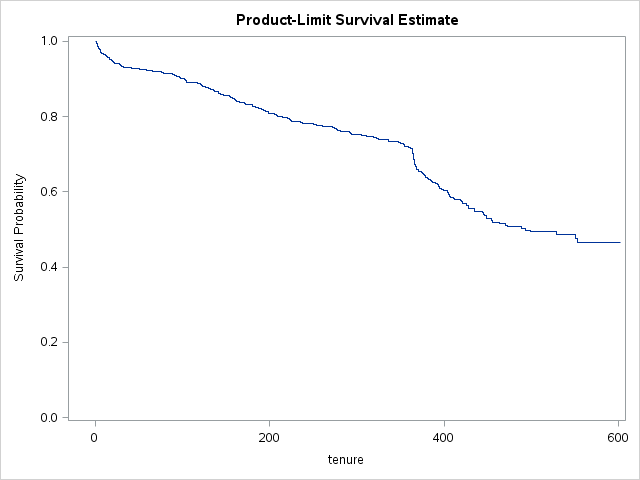

In [6]:
ods listing;
proc lifetest data=tidy_data 
              method=KM                  /* use KM estimator */
              plots=(survival(nocensor)) /* plot survival curve */
              outs=datapath.survival     /* output survival estimates */
              notable;                      
   time tenure * status(1);              /* status: 1-censored */
   *strata market;
   *strata market channel;
run;


In [7]:
* Take a look at the output data set of survival estimates;
proc sql outobs=5;
   select * from datapath.survival;
quit;

tenure,Censoring Flag: 0=Failed 1=Censored,Survival Distribution Function Estimate,SDF Lower 95.00% Confidence Limit,SDF Upper 95.00% Confidence Limit
0,.,1,1,1
1,0,0.99439,0.985122,0.997891
2,0,0.987377,0.975881,0.993412
2,1,0.987377,.,.
3,0,0.985973,0.974087,0.992428
